<a href="https://colab.research.google.com/github/zhiheng-qian/cs4875-research/blob/main/Simple_and_Scalable_Predictive_Uncertainty_Estimation_using_Deep_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles. 

Balaji Lakshminarayanan Alexander Pritzel Charles Blundell

Paper source: https://arxiv.org/pdf/1612.01474v3.pdf

Summary: The idea of ensemble is motivated from MC-dropout in Bayesian neural network by Gal and Ghahramani[1]. It can compute predictive uncertainty estimation, which is computational efficient and scalable, yet performs better compared to Bayesian methods.

Problem: performance drops for adversarial training when the number of ensembles increases.

[1]: Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning https://arxiv.org/abs/1506.02142


Proper score rules:
1. $S(p_\theta , (y, \textbf{x} )) = log{p_\theta}(y|\textbf{x})$ when maximizing likelihood, as $S(p_\theta, q) = \mathbb{E}_{q(x)} q(y|\textbf{x}log{p_\theta}(y|\textbf{x})) \leq \mathbb{E}_{q(x)} q(y|\textbf{x}log{q}(y|\textbf{x}))$

2. In multi-class K-way classification, softmax cross entropy is equivalent to log likelihood.

3. Brier score: $\mathcal{L}(\theta) = -S(p\theta, (y,\textbf{x})) = K^{-1}\Sigma_{k=1}^K(\delta_{k=y} - p_\theta(y=k|\textbf{x}))^2$ (squared error between the predictive probability of a label and one-hot encoding of the correct label.)

For regression:
The common loss function such as MSE does not reflect on predictive uncertainty. A trick is to predict two values: predicted mean $\mu(x)$,  $variance$ :$\sigma^2 > 0$. Treating them as sample from Gaussian distribution, the loss function negative log-likelihood then is:

$-log{p_\theta}(y_n|\textbf{x}_n)  =   \frac{log{\sigma_\theta^2}(\textbf{x})}{2} + \frac{(y-\mu_\theta(\textbf{x}))^2}{2\sigma_\theta^2(\textbf{x})} + c$

Further investigation: 
1. Maximum likelihood estimation over $\mu_\theta (x)$ and $\sigma_\theta^2(x)$ might overfit; one could impose a prior and perform maximum-a-posteriori (MAP) estimation. 
2. In cases where the Gaussian is too-restrictive, one could use a complex distribution e.g. mixture density network or a heavy-tailed distribution.

Adversarial training: "use of adversarial training for predictive uncertainty estimation"

Ensemble: "We used the entire training dataset to train each network since deep NNs typically perform better with more data, although it is straightforward to use a random subsample if need be. We found that random initialization of the NN parameters, along with random shuffling of the data points, was sufficient to obtain good performance in practice."

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
m = nn.Softplus()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Regression on toy datasets<h1/>

$ y = x^3 + \epsilon$ where $\epsilon \backsim \mathcal{N}(0, 3^2)$

Baseline: Train single neural network to minimize MSE

1. Ensemble: Empirical variance of 5 networks trained using MSE
2. Baseline+NLL: Effect of training using NLL using a single net
3. Baseline+NLL+adversarial training: Additional effect of adversarial training
4. Ensemble+NLL+adversarial training: Effect of using an ensemble of 5 networks

<h2>Baseline<h2/>

In [3]:
np.random.seed(2)
x_train = np.random.uniform(-4, 4, 20)
y_train = np.power(x_train, 3) + np.random.normal(0, 3, 20)

xx = np.linspace(-6, 6, 100)
yy = np.power(xx, 3)

# fig, ax = plt.subplots(1)
# ax.plot(xx, yy, 'b')
# ax.plot(x_train, y_train, 'ro')

Based on the experiment setup by Herna ́ndez-Lobato and Adams, we use a single layer network with 100 hidden units. 

In [4]:
class SingleNet(nn.Module):
  def __init__(self):
    super(SingleNet, self).__init__()
    self.l1 = nn.Linear(1, 100)
    self.l2 = nn.Linear(100, 1)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    return x

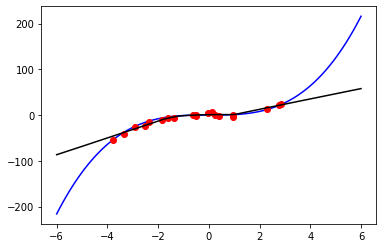

In [5]:
model = SingleNet()
learning_rate = 0.01
numEpochs = 40
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(numEpochs):
    for x, y in zip(x_train, y_train):
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()
    #print('Loss at epoch {} is {}'.format(epoch, loss))

x_test = np.linspace(-6, 6, 100)
y_test = []
for x in x_test:
  x = torch.tensor([x], dtype = torch.float)
  y_test.append(model(x))
y_test = np.hstack(torch.stack(y_test).detach().numpy())

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, y_test, 'k')

In [6]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/baseline.png')

<h2>Ensemble<h2/>

An ensemble of 5 NNs to get multiple predictions and empirical variance of predictions as an approximate measure of uncertainty.

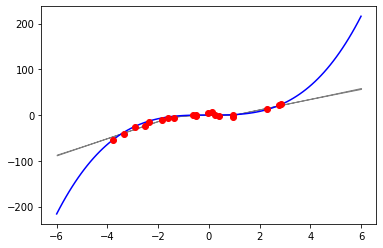

In [7]:
def ensemble(model, optimizer):
  for epoch in range(numEpochs):
      for x, y in zip(x_train, y_train):
          x = torch.tensor([x], dtype = torch.float)
          y = torch.tensor([y], dtype = torch.float)
          optimizer.zero_grad()
          y_pred = model(x)
          loss = loss_func(y_pred, y)
          loss.backward()
          optimizer.step()
      #print('Loss at epoch {} is {}'.format(epoch, loss))

  x_test = np.linspace(-6, 6, 100)
  y_test = []
  for x in x_test:
    x = torch.tensor([x], dtype = torch.float)
    y_test.append(model(x))
  y_test = np.hstack(torch.stack(y_test).detach().numpy())
  return y_test

y_tests = []
for i in range(5):
  model = SingleNet()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  y_tests.append(ensemble(model, optimizer))

y_tests = np.vstack(y_tests)
mu = np.mean(y_tests, 0)
var = np.var(y_tests, 0)


fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
# ax.plot(x_test, mu, 'k')
ax.fill_between(xx, mu+var, mu-var, color='grey')


In [8]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/ensemble.png')

<h2>Baseline+NLL<h2/>

We use the probabilistic model from the paper which outputs two value in the final layer, predicted mean $\mu(x)$ and variance respectively.

In [9]:
def nll_loss(mu, var, y_train):
  return 0.5*torch.log(var) + 0.5*(y_train - mu)**2/var

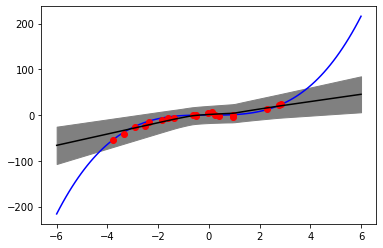

In [10]:
class SingleNetNll(nn.Module):
  def __init__(self):
    super(SingleNetNll, self).__init__()
    self.l1 = nn.Linear(1, 100)
    self.l2 = nn.Linear(100, 2)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    return x

class SingleProbNetNll(nn.Module):
  def __init__(self):
    super(SingleProbNetNll, self).__init__()
    self.l1 = nn.Linear(1, 100)
    # self.l2 = nn.Linear(100, 100)
    self.mean_head = nn.Linear(100, 1)
    self.var_head = nn.Linear(100, 1)

  def forward(self, x):
    x = F.relu(self.l1(x))
    # x = F.relu(self.l2(x))
    mean_x = self.mean_head(x)
    var_x = F.elu(self.var_head(x)) + 1.0
    return mean_x, var_x

model = SingleProbNetNll()
learning_rate = 0.01
numEpochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(numEpochs):
    for x, y in zip(x_train, y_train):
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
        optimizer.zero_grad()
        output = model(x)
        loss = nll_loss(output[0], output[1], y)
        # loss = nll_loss(output[0], m(output[1])+ 1e-06, y)
        loss.backward()
        optimizer.step()
    #print('Loss at epoch {} is {}'.format(epoch, loss))

x_test = np.linspace(-6, 6, 100)
mu_test = []
var_test = []
for x in x_test:
  x = torch.tensor([x], dtype = torch.float)
  mu_test.append(model(x)[0])
  var_test.append(model(x)[1])

mu_test = np.hstack(torch.stack(mu_test).detach().numpy())
var_test = np.hstack(torch.stack(var_test).detach().numpy())

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, mu_test, 'k')
ax.fill_between(xx, mu_test+var_test, mu_test-var_test, color='grey')

In [11]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/baseline+nll.png')

<h2>Baseline+NLL+adversarial training<h2/>

Adversarial sample $\textbf{x}' = \textbf{x} + \epsilon sign(\nabla_{\textbf{x}} \ell(\theta, \textbf{x}, y)) $

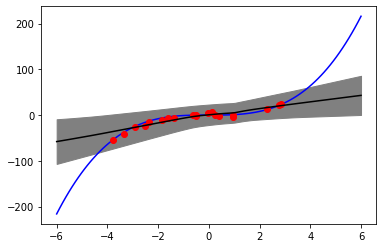

In [12]:
model = SingleProbNetNll()
learning_rate = 0.01
numEpochs = 40
eps = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(numEpochs):
    for x, y in zip(x_train, y_train):
        x = torch.tensor([x], dtype = torch.float, requires_grad=True)
        y = torch.tensor([y], dtype = torch.float)
        optimizer.zero_grad()
        output = model(x)
        loss = nll_loss(output[0], output[1], y)
        # loss = nll_loss(output[0], m(output[1])+ 1e-06, y)
        loss.backward(retain_graph=True)

        x_prime = x + eps*(torch.sign(x.grad))
        optimizer.zero_grad()
        output_prime = model(x_prime)
        loss = nll_loss(output[0], m(output[1])+ 1e-06, y) + nll_loss(output_prime[0], m(output_prime[1])+ 1e-06, y)
        loss.backward()

        optimizer.step()
    #print('Loss at epoch {} is {}'.format(epoch, loss))

x_test = np.linspace(-6, 6, 100)
mu_test = []
var_test = []
for x in x_test:
  x = torch.tensor([x], dtype = torch.float)
  mu_test.append(model(x)[0])
  var_test.append(model(x)[1])

mu_test = np.hstack(torch.stack(mu_test).detach().numpy())
var_test = np.hstack(torch.stack(var_test).detach().numpy())

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, mu_test, 'k')
ax.fill_between(xx, mu_test+var_test, mu_test-var_test, color='grey')

In [13]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/baseline+nll+adv.png')

<h2>Ensemble+NLL+adversarial training<h2/>

$\mu_*(\textbf{x}) = M^{-1} \Sigma_{m} \mu_{\theta_m}(\textbf{x}) $

$\sigma_*^2 (\textbf{x}) = M^{-1}\Sigma_m (\sigma^2_{\theta_m} (\textbf{x}) + \mu^2_{\theta_m}(\textbf{x})) - \mu^2_*(\textbf{x})$

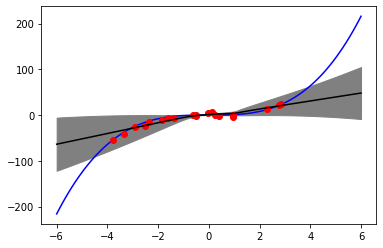

In [14]:
def ensembleWithAdversarial(model, optimizer):
  for epoch in range(numEpochs):
      for x, y in zip(x_train, y_train):
          x = torch.tensor([x], dtype = torch.float, requires_grad=True)
          y = torch.tensor([y], dtype = torch.float)
          optimizer.zero_grad()
          output = model(x)
          loss = nll_loss(output[0], output[1], y)
          # loss = nll_loss(output[0], m(output[1])+ 1e-06, y)
          loss.backward(retain_graph=True)

          x_prime = x + eps*(torch.sign(x.grad.data.sign()))
          optimizer.zero_grad()
          output_prime = model(x_prime)
          loss = nll_loss(output[0], m(output[1])+ 1e-06, y) + nll_loss(output_prime[0], m(output_prime[1])+ 1e-06, y)
          loss.backward()

          optimizer.step()
      # print('Loss at epoch {} is {}'.format(epoch, loss.item()))

  x_test = np.linspace(-6, 6, 100)
  mu_test = []
  var_test = []
  for x in x_test:
    x = torch.tensor([x], dtype = torch.float)
    mu_test.append(model(x)[0])
    var_test.append(model(x)[0])
  mu_test = np.hstack(torch.stack(mu_test).detach().numpy())
  var_test = np.hstack(torch.stack(var_test).detach().numpy())
  return mu_test, var_test

mu_tests = []
var_tests = []
for i in range(5):
  model = SingleProbNetNll()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  mu_test, var_test = ensembleWithAdversarial(model, optimizer)
  mu_tests.append(mu_test)
  var_tests.append(var_test)

mu_tests = np.vstack(mu_tests)
var_tests = np.vstack(var_tests)

mu_optimal = np.mean(mu_tests, 0)
var_optimal = np.mean(mu_tests*mu_tests + var_tests, 0) - mu_optimal*mu_optimal

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, mu_optimal, 'k')
ax.fill_between(xx, mu_optimal+var_optimal, mu_optimal-var_optimal, color='grey')


In [15]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/ensemble+nll+adv.png')

<h2>Classification with CIFAR-10 and ResNet <h2/>

In [16]:
# ResNet implementation is based on deep learning course (2020) assignment from Aalto university 
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, stride=stride, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, bias=False, stride=1, padding = 1),
            nn.BatchNorm2d(out_channels)
        )
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
               nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
               nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv(x)
        out += self.skip(x)
        out = torch.relu(out)
        return out

class GroupOfBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, n_blocks, stride=1):
        super(GroupOfBlocks, self).__init__()

        first_block = Block(in_channels, out_channels, stride)
        other_blocks = [Block(out_channels, out_channels) for _ in range(1, n_blocks)]
        self.group = nn.Sequential(first_block, *other_blocks)

    def forward(self, x):
        return self.group(x)

class ResNet(nn.Module):
    def __init__(self, n_blocks, n_channels=64, num_classes=10):
        """
        Args:
          n_blocks (list):   A list with three elements which contains the number of blocks in 
                             each of the three groups of blocks in ResNet.
                             For instance, n_blocks = [2, 4, 6] means that the first group has two blocks,
                             the second group has four blocks and the third one has six blocks.
          n_channels (int):  Number of channels in the first group of blocks.
          num_classes (int): Number of classes.
        """
        assert len(n_blocks) == 3, "The number of groups should be three."
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.group1 = GroupOfBlocks(n_channels, n_channels, n_blocks[0])
        self.group2 = GroupOfBlocks(n_channels, 2*n_channels, n_blocks[1], stride=2)
        self.group3 = GroupOfBlocks(2*n_channels, 4*n_channels, n_blocks[2], stride=2)

        self.avgpool = nn.AvgPool2d(kernel_size=4, stride=1)
        self.fc = nn.Linear(4*n_channels, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 3, 32, 32): Input images.
          verbose: True if you want to print the shapes of the intermediate variables.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        if verbose: print(x.shape)
        x = self.conv1(x)
        if verbose: print('conv1:  ', x.shape)
        x = self.bn1(x)
        if verbose: print('bn1:    ', x.shape)
        x = self.relu(x)
        if verbose: print('relu:   ', x.shape)
        x = self.maxpool(x)
        if verbose: print('maxpool:', x.shape)

        x = self.group1(x)
        if verbose: print('group1: ', x.shape)
        x = self.group2(x)
        if verbose: print('group2: ', x.shape)
        x = self.group3(x)
        if verbose: print('group3: ', x.shape)

        x = self.avgpool(x)
        if verbose: print('avgpool:', x.shape)

        x = x.view(-1, self.fc.in_features)
        if verbose: print('x.view: ', x.shape)
        x = self.fc(x)
        if verbose: print('out:    ', x.shape)

        return x

Loading CIFAR10

In [17]:
import torchvision
import torchvision.transforms as transforms
data_dir = '/content/drive/My Drive/AALTO/cs4875-research/data/'
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


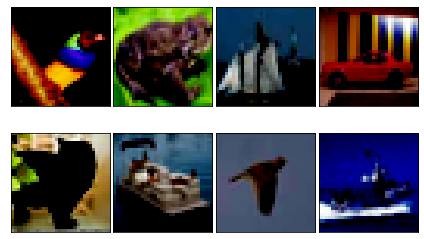

In [18]:
images, labels = iter(trainloader).next()
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        # ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)
plot_images(images[:8], n_rows=2)

In [19]:
images[0]


tensor([[[-0.6941, -0.7020, -0.7255,  ..., -0.7412, -0.7412, -0.7255],
         [-0.6706, -0.6941, -0.7255,  ..., -0.7569, -0.7490, -0.7490],
         [-0.6549, -0.6863, -0.7255,  ..., -0.7647, -0.7490, -0.7412],
         ...,
         [-0.7333, -0.7176, -0.7020,  ..., -0.7020, -0.7176, -0.7176],
         [-0.7412, -0.7255, -0.5294,  ..., -0.7020, -0.7098, -0.7176],
         [-0.7098, -0.6627, -0.3490,  ..., -0.7020, -0.7098, -0.7176]],

        [[-0.9451, -0.9373, -0.9373,  ..., -0.9059, -0.9216, -0.9216],
         [-0.9059, -0.9137, -0.9294,  ..., -0.9216, -0.9216, -0.9373],
         [-0.8902, -0.9059, -0.9294,  ..., -0.9294, -0.9216, -0.9373],
         ...,
         [-0.9294, -0.9451, -0.9059,  ..., -0.9529, -0.9529, -0.9451],
         [-0.9373, -0.9059, -0.6392,  ..., -0.9529, -0.9451, -0.9451],
         [-0.9137, -0.8510, -0.4588,  ..., -0.9529, -0.9529, -0.9451]],

        [[-0.9216, -0.9216, -0.9294,  ..., -0.9294, -0.9451, -0.9529],
         [-0.9216, -0.9373, -0.9529,  ..., -0

In [25]:
device = torch.device('cuda:0')
loss_func = nn.CrossEntropyLoss()
m = nn.LogSoftmax(dim=1)
eps = 0.01*2 # input ranges from (-1, 1)

def ensembleWithAdversarial(model, optimizer):
  running_loss = 0.0
  for epoch in range(numEpochs):
    # model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        x = x.clone().detach().requires_grad_(True)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(output, y)
        loss.backward(retain_graph=True)
        x_prime = x + eps*(torch.sign(x.grad.data))
        optimizer.zero_grad()
        output_prime = model(x_prime)
        loss = loss_func(output, y) + loss_func(output_prime, y)
        loss.backward()
        optimizer.step()
    if epoch == (numEpochs-1):
      running_loss = loss.item()
    print('Loss at epoch {} is {}'.format(epoch, loss.item()))
  return running_loss


numEpochs = 40
n_blocks = [2, 2, 2]  # number of blocks in the three groups
training_loss = []
for i in range(5):
  model = ResNet(n_blocks, n_channels=16)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  training_loss.append(ensembleWithAdversarial(model, optimizer))
print('NLL Loss is {}'.format(np.mean(training_loss)))


Loss at epoch 0 is 2.279128074645996
Loss at epoch 1 is 2.197066307067871
Loss at epoch 2 is 3.0229055881500244
Loss at epoch 3 is 2.508955955505371
Loss at epoch 4 is 2.4903926849365234
Loss at epoch 5 is 1.5625182390213013
Loss at epoch 6 is 1.4893214702606201
Loss at epoch 7 is 1.7983486652374268
Loss at epoch 8 is 2.01196551322937
Loss at epoch 9 is 2.5150604248046875
Loss at epoch 10 is 2.011514902114868
Loss at epoch 11 is 1.050114393234253
Loss at epoch 12 is 1.4568043947219849
Loss at epoch 13 is 1.9528743028640747
Loss at epoch 14 is 1.3803523778915405
Loss at epoch 15 is 1.5095394849777222
Loss at epoch 16 is 1.5066810846328735
Loss at epoch 17 is 1.0617777109146118
Loss at epoch 18 is 0.8524408340454102
Loss at epoch 19 is 1.1635488271713257
Loss at epoch 20 is 1.2777116298675537
Loss at epoch 21 is 1.2670934200286865
Loss at epoch 22 is 1.10416841506958
Loss at epoch 23 is 0.8038582801818848
Loss at epoch 24 is 0.5207080841064453
Loss at epoch 25 is 1.3755993843078613
Loss 

In [23]:
training_loss

[0.8379942178726196,
 1.2611010074615479,
 2.007901906967163,
 1.806257724761963,
 1.6851325035095215]

In [24]:
np.mean(training_loss)

1.519677472114563

Reference:
1. Paper review & code: Deep Ensembles (NIPS 2017). Alberto Arrigoni. https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
2. Deep ensemble. Github: cameronccohen. https://github.com/cameronccohen/deep-ensembles/blob/master/Tutorial.ipynb
3. 68–95–99.7 rule. Wiki. https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule